# Regression Week 5: Feature Selection and LASSO (Interpretation)

In this notebook, you will use LASSO to select features, building on a pre-implemented solver for LASSO (using GraphLab Create, though you can use other solvers). You will:
* Run LASSO with different L1 penalties.
* Choose best L1 penalty using a validation set.
* Choose best L1 penalty using a validation set, with additional constraint on the size of subset.

In the second notebook, you will implement your own LASSO solver, using coordinate descent. 

# Fire up graphlab create

In [1]:
import graphlab

# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [3]:
sales = graphlab.SFrame('kc_house_data.gl/')

# Create new features

As in Week 2, we consider features that are some transformations of inputs.

In [4]:
from math import log, sqrt
sales['sqft_living_sqrt'] = sales['sqft_living'].apply(sqrt)
sales['sqft_lot_sqrt'] = sales['sqft_lot'].apply(sqrt)
sales['bedrooms_square'] = sales['bedrooms']*sales['bedrooms']

# In the dataset, 'floors' was defined with type string, 
# so we'll convert them to float, before creating a new feature.
sales['floors'] = sales['floors'].astype(float) 
sales['floors_square'] = sales['floors']*sales['floors']

* Squaring bedrooms will increase the separation between not many bedrooms (e.g. 1) and lots of bedrooms (e.g. 4) since 1^2 = 1 but 4^2 = 16. Consequently this variable will mostly affect houses with many bedrooms.
* On the other hand, taking square root of sqft_living will decrease the separation between big house and small house. The owner may not be exactly twice as happy for getting a house that is twice as big.

# Learn regression weights with L1 penalty

Let us fit a model with all the features available, plus the features we just created above.

In [5]:
all_features = ['bedrooms', 'bedrooms_square',
            'bathrooms',
            'sqft_living', 'sqft_living_sqrt',
            'sqft_lot', 'sqft_lot_sqrt',
            'floors', 'floors_square',
            'waterfront', 'view', 'condition', 'grade',
            'sqft_above',
            'sqft_basement',
            'yr_built', 'yr_renovated']

Applying L1 penalty requires adding an extra parameter (`l1_penalty`) to the linear regression call in GraphLab Create. (Other tools may have separate implementations of LASSO.)  Note that it's important to set `l2_penalty=0` to ensure we don't introduce an additional L2 penalty.

In [6]:
model_all = graphlab.linear_regression.create(sales, target='price', features=all_features,
                                              validation_set=None, 
                                              l2_penalty=0., l1_penalty=1e10)

PROGRESS: Linear regression:
PROGRESS: --------------------------------------------------------
PROGRESS: Number of examples          : 21613
PROGRESS: Number of features          : 17
PROGRESS: Number of unpacked features : 17
PROGRESS: Number of coefficients    : 18
PROGRESS: Starting Accelerated Gradient (FISTA)
PROGRESS: --------------------------------------------------------
PROGRESS: +-----------+----------+-----------+--------------+--------------------+---------------+
PROGRESS: | Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |
PROGRESS: +-----------+----------+-----------+--------------+--------------------+---------------+
PROGRESS: Tuning step size. First iteration could take longer than subsequent iterations.
PROGRESS: | 1         | 2        | 0.000002  | 1.452101     | 6962915.603493     | 426631.749026 |
PROGRESS: | 2         | 3        | 0.000002  | 1.487265     | 6843144.200219     | 392488.929838 |
PROGRESS: | 3         | 4      

Find what features had non-zero weight.

In [8]:
model_all.get("coefficients").print_rows(num_rows = len(all_features)) 

+------------------+-------+---------------+
|       name       | index |     value     |
+------------------+-------+---------------+
|   (intercept)    |  None |  274873.05595 |
|     bedrooms     |  None |      0.0      |
| bedrooms_square  |  None |      0.0      |
|    bathrooms     |  None | 8468.53108691 |
|   sqft_living    |  None | 24.4207209824 |
| sqft_living_sqrt |  None | 350.060553386 |
|     sqft_lot     |  None |      0.0      |
|  sqft_lot_sqrt   |  None |      0.0      |
|      floors      |  None |      0.0      |
|  floors_square   |  None |      0.0      |
|    waterfront    |  None |      0.0      |
|       view       |  None |      0.0      |
|    condition     |  None |      0.0      |
|      grade       |  None | 842.068034898 |
|    sqft_above    |  None | 20.0247224171 |
|  sqft_basement   |  None |      0.0      |
|     yr_built     |  None |      0.0      |
+------------------+-------+---------------+
[18 rows x 3 columns]



Note that a majority of the weights have been set to zero. So by setting an L1 penalty that's large enough, we are performing a subset selection. 

***QUIZ QUESTION***:
According to this list of weights, which of the features have been chosen? 

# Selecting an L1 penalty

To find a good L1 penalty, we will explore multiple values using a validation set. Let us do three way split into train, validation, and test sets:
* Split our sales data into 2 sets: training and test
* Further split our training data into two sets: train, validation

Be *very* careful that you use seed = 1 to ensure you get the same answer!

In [9]:
(training_and_validation, testing) = sales.random_split(.9,seed=1) # initial train/test split
(training, validation) = training_and_validation.random_split(0.5, seed=1) # split training into train and validate

Next, we write a loop that does the following:
* For `l1_penalty` in [10^1, 10^1.5, 10^2, 10^2.5, ..., 10^7] (to get this in Python, type `np.logspace(1, 7, num=13)`.)
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list.
    * Compute the RSS on VALIDATION data (here you will want to use `.predict()`) for that `l1_penalty`
* Report which `l1_penalty` produced the lowest RSS on validation data.

When you call `linear_regression.create()` make sure you set `validation_set = None`.

Note: you can turn off the print out of `linear_regression.create()` with `verbose = False`

In [16]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [14]:
stor = []    
for l1_penalty in np.logspace(1, 7, num=13):
    model =  graphlab.linear_regression.create(training, target='price', features=all_features,
                                              validation_set=None,l2_penalty=0., l1_penalty=l1_penalty,verbose = False)
    prediction = model.predict(validation)
    e = validation["price"] - prediction
    RSS = sum(e*e)
    stor.append([l1_penalty,RSS])
    
#print stor        

[[10.0, 625766285142461.2], [31.622776601683793, 625766285362395.2], [100.0, 625766286057887.0], [316.22776601683796, 625766288257224.9], [1000.0, 625766295212186.0], [3162.2776601683795, 625766317206077.8], [10000.0, 625766386760661.5], [31622.776601683792, 625766606749281.4], [100000.0, 625767302791633.4], [316227.76601683791, 625769507643885.1], [1000000.0, 625776517727025.8], [3162277.6601683795, 625799062845466.9], [10000000.0, 625883719085424.5]]


0 -----------> 6.25766285142e+14 ====== 10.0
1 -----------> 6.25766285362e+14 ====== 31.6227766017
2 -----------> 6.25766286058e+14 ====== 100.0
3 -----------> 6.25766288257e+14 ====== 316.227766017
4 -----------> 6.25766295212e+14 ====== 1000.0
5 -----------> 6.25766317206e+14 ====== 3162.27766017
6 -----------> 6.25766386761e+14 ====== 10000.0
7 -----------> 6.25766606749e+14 ====== 31622.7766017
8 -----------> 6.25767302792e+14 ====== 100000.0
9 -----------> 6.25769507644e+14 ====== 316227.766017
10 -----------> 6.25776517727e+14 ====== 1000000.0
11 -----------> 6.25799062845e+14 ====== 3162277.66017
12 -----------> 6.25883719085e+14 ====== 10000000.0


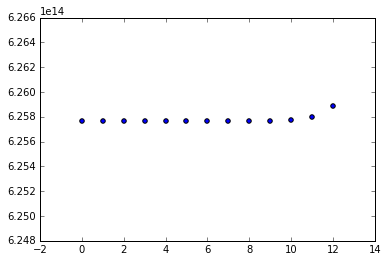

In [20]:
for k in range(len(stor)):
    print k,"----------->",stor[k][1],"======", stor[k][0]
    plt.scatter(k,stor[k][1])

*** QUIZ QUESTIONS ***
1. What was the best value for the `l1_penalty`?
2. What is the RSS on TEST data of the model with the best `l1_penalty`?

***QUIZ QUESTION***
Also, using this value of L1 penalty, how many nonzero weights do you have?

In [21]:
model_all = graphlab.linear_regression.create(sales, target='price', features=all_features,
                                              validation_set=None, 
                                              l2_penalty=0., l1_penalty=10.0)

PROGRESS: Linear regression:
PROGRESS: --------------------------------------------------------
PROGRESS: Number of examples          : 21613
PROGRESS: Number of features          : 17
PROGRESS: Number of unpacked features : 17
PROGRESS: Number of coefficients    : 18
PROGRESS: Starting Accelerated Gradient (FISTA)
PROGRESS: --------------------------------------------------------
PROGRESS: +-----------+----------+-----------+--------------+--------------------+---------------+
PROGRESS: | Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |
PROGRESS: +-----------+----------+-----------+--------------+--------------------+---------------+
PROGRESS: Tuning step size. First iteration could take longer than subsequent iterations.
PROGRESS: | 1         | 2        | 0.000002  | 0.408038     | 6306018.232993     | 313413.344721 |
PROGRESS: | 2         | 3        | 0.000002  | 0.442501     | 6019513.777487     | 293369.342637 |
PROGRESS: | 3         | 4      

In [22]:
model_all.get("coefficients").print_rows(num_rows = len(all_features)) 

+------------------+-------+------------------+
|       name       | index |      value       |
+------------------+-------+------------------+
|   (intercept)    |  None |  20459.2475219   |
|     bedrooms     |  None |  8155.38098737   |
| bedrooms_square  |  None |  1479.73787423   |
|    bathrooms     |  None |  24576.2383172   |
|   sqft_living    |  None |  37.4911504798   |
| sqft_living_sqrt |  None |  1109.39597073   |
|     sqft_lot     |  None | -0.0168499198461 |
|  sqft_lot_sqrt   |  None |  149.569423985   |
|      floors      |  None |  20983.5137368   |
|  floors_square   |  None |  12278.1023451   |
|    waterfront    |  None |  581971.306649   |
|       view       |  None |  92988.9899686   |
|    condition     |  None |  6924.28719657   |
|      grade       |  None |  6205.64105779   |
|    sqft_above    |  None |  41.3497390696   |
|  sqft_basement   |  None |   118.23242135   |
|     yr_built     |  None |  10.1881669529   |
+------------------+-------+------------

In [23]:
len(all_features)

17

# Limit the number of nonzero weights

What if we absolutely wanted to limit ourselves to, say, 7 features? This may be important if we want to derive "a rule of thumb" --- an interpretable model that has only a few features in them.

In this section, you are going to implement a simple, two phase procedure to achive this goal:
1. Explore a large range of `l1_penalty` values to find a narrow region of `l1_penalty` values where models are likely to have the desired number of non-zero weights.
2. Further explore the narrow region you found to find a good value for `l1_penalty` that achieves the desired sparsity.  Here, we will again use a validation set to choose the best value for `l1_penalty`.

In [24]:
max_nonzeros = 7

## Exploring the larger range of values to find a narrow range with the desired sparsity

Let's define a wide range of possible `l1_penalty_values`:

In [25]:
l1_penalty_values = np.logspace(8, 10, num=20)

Now, implement a loop that search through this space of possible `l1_penalty` values:

* For `l1_penalty` in `np.logspace(8, 10, num=20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Extract the weights of the model and count the number of nonzeros. Save the number of nonzeros to a list.
        * *Hint: `model['coefficients']['value']` gives you an SArray with the parameters you learned.  If you call the method `.nnz()` on it, you will find the number of non-zero parameters!* 

In [28]:
stor_2 = []
for l1_penalty in np.logspace(8, 10, num=20):
    model =  graphlab.linear_regression.create(training, target='price', features=all_features,
                                              validation_set=None,l2_penalty=0., l1_penalty=l1_penalty,verbose = False)
    coeff = model['coefficients']['value']
    nb = coeff.nnz()
    stor_2.append([l1_penalty,nb])
    if nb ==7:
        print l1_penalty

In [29]:
stor_2

[[100000000.0, 18],
 [127427498.57031322, 18],
 [162377673.91887242, 18],
 [206913808.11147901, 18],
 [263665089.87303555, 17],
 [335981828.62837881, 17],
 [428133239.8719396, 17],
 [545559478.11685145, 17],
 [695192796.17755914, 17],
 [885866790.41008317, 16],
 [1128837891.6846883, 15],
 [1438449888.2876658, 15],
 [1832980710.8324375, 13],
 [2335721469.0901213, 12],
 [2976351441.6313133, 10],
 [3792690190.7322536, 6],
 [4832930238.5717525, 5],
 [6158482110.6602545, 3],
 [7847599703.5146227, 1],
 [10000000000.0, 1]]

Out of this large range, we want to find the two ends of our desired narrow range of `l1_penalty`.  At one end, we will have `l1_penalty` values that have too few non-zeros, and at the other end, we will have an `l1_penalty` that has too many non-zeros.  

More formally, find:
* The largest `l1_penalty` that has more non-zeros than `max_nonzero` (if we pick a penalty smaller than this value, we will definitely have too many non-zero weights)
    * Store this value in the variable `l1_penalty_min` (we will use it later)
* The smallest `l1_penalty` that has fewer non-zeros than `max_nonzero` (if we pick a penalty larger than this value, we will definitely have too few non-zero weights)
    * Store this value in the variable `l1_penalty_max` (we will use it later)


*Hint: there are many ways to do this, e.g.:*
* Programmatically within the loop above
* Creating a list with the number of non-zeros for each value of `l1_penalty` and inspecting it to find the appropriate boundaries.

In [30]:
l1_penalty_min = 2976351441.6313133
l1_penalty_max = 3792690190.7322536

***QUIZ QUESTIONS***

What values did you find for `l1_penalty_min` and`l1_penalty_max`? 

## Exploring the narrow range of values to find the solution with the right number of non-zeros that has lowest RSS on the validation set 

We will now explore the narrow region of `l1_penalty` values we found:

In [31]:
l1_penalty_values = np.linspace(l1_penalty_min,l1_penalty_max,20)

* For `l1_penalty` in `np.linspace(l1_penalty_min,l1_penalty_max,20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Measure the RSS of the learned model on the VALIDATION set

Find the model that the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzero`.

In [35]:
stor_3 = []
stor_4 = []
for l1_penalty in np.linspace(l1_penalty_min,l1_penalty_max,20):
    model =  graphlab.linear_regression.create(training, target='price', features=all_features,
                                                validation_set=None,l2_penalty=0., l1_penalty=l1_penalty,verbose = False)
   
    #---------- find coeff----------------------                                           
    coeff = model['coefficients']['value']
    nb = coeff.nnz()
    stor_4.append([l1_penalty,nb])
                                               
    if nb ==7:
        print l1_penalty                                         
        prediction = model.predict(validation)
        e = validation["price"] - prediction
        RSS = sum(e*e)
        stor_3.append([l1_penalty,RSS])

3448968612.16
3491933809.48
3534899006.81
3577864204.13


In [38]:
stor_3

[[3448968612.1634369, 1046937488751713.6],
 [3491933809.484539, 1051147625612863.0],
 [3534899006.8056412, 1055992735342999.2],
 [3577864204.1267428, 1060799531763290.2]]

 0 -----------> 1.04693748875e+15 ====== 3448968612.16
1 -----------> 1.05114762561e+15 ====== 3491933809.48
2 -----------> 1.05599273534e+15 ====== 3534899006.81
3 -----------> 1.06079953176e+15 ====== 3577864204.13


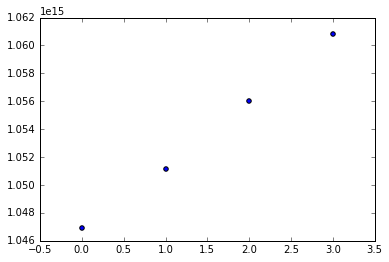

In [42]:
for k in range(len(stor_3)):
    print k,"----------->",stor_3[k][1],"======", stor_3[k][0]
    plt.scatter(k,stor_3[k][1])

***QUIZ QUESTIONS***
1. What value of `l1_penalty` in our narrow range has the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzeros`?
2. What features in this model have non-zero coefficients?

In [43]:
model_last =  graphlab.linear_regression.create(training, target='price', features=all_features,
                                              validation_set=None,l2_penalty=0., l1_penalty=3448968612.1,verbose = False)


In [44]:
model_last.get("coefficients").print_rows(num_rows = len(all_features)) 

+------------------+-------+---------------+
|       name       | index |     value     |
+------------------+-------+---------------+
|   (intercept)    |  None | 222253.192544 |
|     bedrooms     |  None | 661.722717782 |
| bedrooms_square  |  None |      0.0      |
|    bathrooms     |  None | 15873.9572593 |
|   sqft_living    |  None | 32.4102214513 |
| sqft_living_sqrt |  None | 690.114773313 |
|     sqft_lot     |  None |      0.0      |
|  sqft_lot_sqrt   |  None |      0.0      |
|      floors      |  None |      0.0      |
|  floors_square   |  None |      0.0      |
|    waterfront    |  None |      0.0      |
|       view       |  None |      0.0      |
|    condition     |  None |      0.0      |
|      grade       |  None | 2899.42026975 |
|    sqft_above    |  None | 30.0115753022 |
|  sqft_basement   |  None |      0.0      |
|     yr_built     |  None |      0.0      |
+------------------+-------+---------------+
[18 rows x 3 columns]

